<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/examples/IntermittentData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Intermitent Time Series

Sparse or intermittent series are series with very few non-zero observations. They are notoriously hard to forecast, and so, different methods have been developed especifically for them.

In this notebook we'll implement and benchmark some of the most popular methods for intermitent forecast using the [StatsForecast](https://nixtla.github.io/statsforecast/) library.

## Installing StatsForecast Library

In [ ]:
%%capture
!pip install -U numba
!pip install -U statsmodels
!pip install statsforecast
!pip install neuralforecast

In [ ]:
import random
import warnings
warnings.filterwarnings('ignore')
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuralforecast.data.datasets import m5
from statsforecast import StatsForecast
from statsforecast.models import (
    ADIDA, CrostonClassic, CrostonOptimized,
    CrostonSBA, IMAPA, TSB, ETS, AutoARIMA
)

plt.rcParams["figure.figsize"] = (9,6)

### Plot functions

In [ ]:
def plot_grid(df_train, plot_titles, model_cols=["y_50"], df_test=None, plot_random=True):
    """Plots multiple time series."""
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train', c='black')
        axes[idx, idy].xaxis.set_tick_params(rotation=45)
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y'], c='black', label='True')

            for col in model_cols:
                axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)

        axes[idx, idy].set_title(f'State: {plot_titles[uid]}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.7)
    plt.show()

## Loading and Exploring the M5 Dataset

The [M5 dataset](https://en.wikipedia.org/wiki/Makridakis_Competitions) consists of real-life data from Walmart and was used on a competition conducted on Kaggle. The data consists of around 42,000 hierarchical daily time series, starting at the level of SKUs and ending with the total demand of some large geographical area.

In [ ]:
Y_df_total, *_ = m5.M5.load('./data')

In [ ]:
print(Y_df_total['unique_id'].nunique())
Y_df_total.head()

30490


,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0


### Prepare dataset for StatsForecast modelling

#### Create a subset of the dataset

In [ ]:
ids = random.sample(list(Y_df_total['unique_id'].unique()), 100)

Y_df = Y_df_total.query('unique_id in @ids')

Y_df["unique_id"] = Y_df["unique_id"].astype(str)

Y_df.head()

,unique_id,ds,y
573344,FOODS_1_035_CA_1,2011-01-29,3.0
573345,FOODS_1_035_CA_1,2011-01-30,5.0
573346,FOODS_1_035_CA_1,2011-01-31,1.0
573347,FOODS_1_035_CA_1,2011-02-01,0.0
573348,FOODS_1_035_CA_1,2011-02-02,0.0


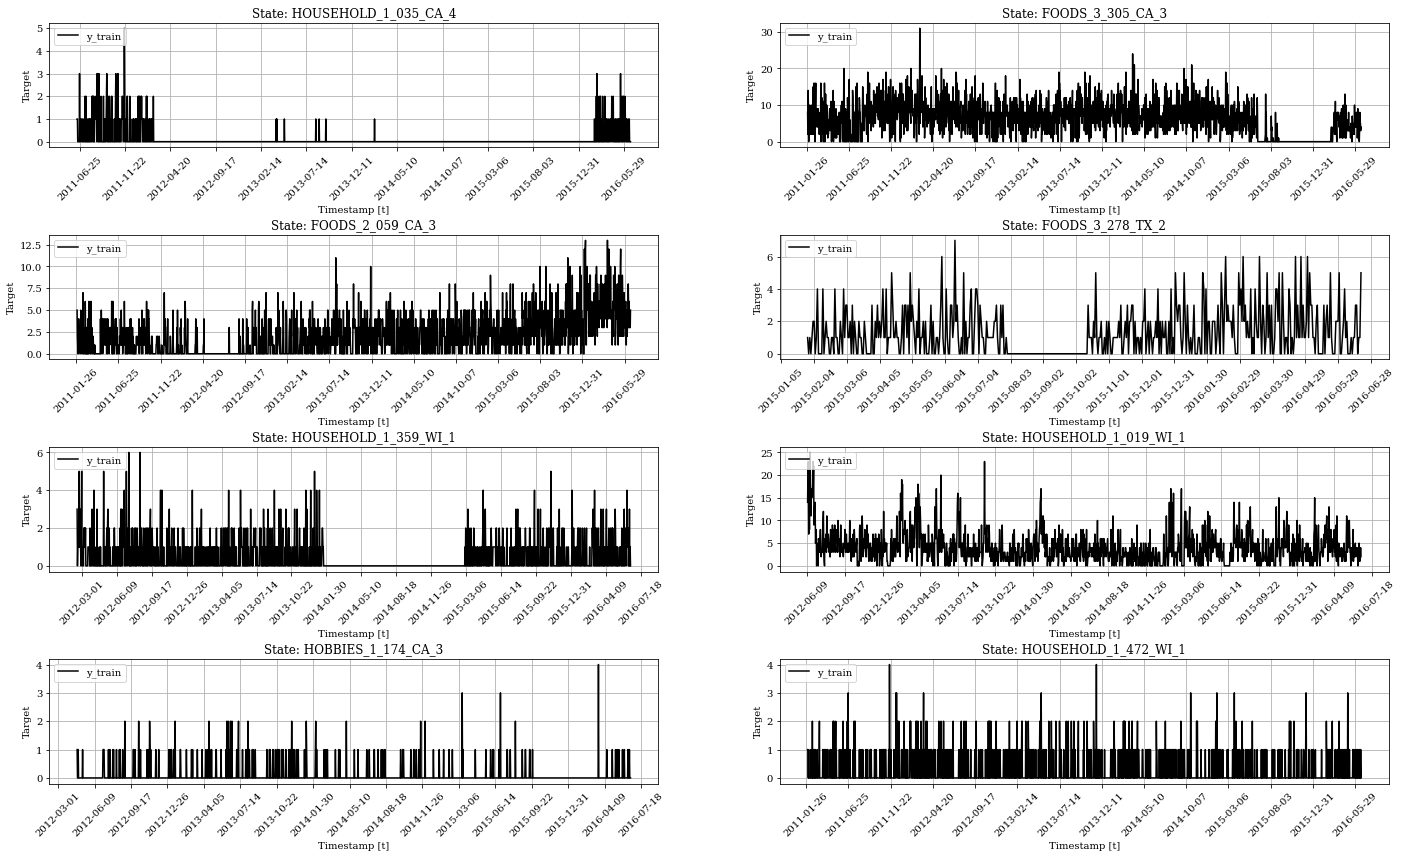

In [ ]:
plot_titles = dict(zip(ids, ids))
plot_grid(Y_df, plot_titles=plot_titles)

## Modelling intermitent data


*   **ADIDA**: Temporal aggregation is used for reducing the presence of zero observations, thus mitigating the undesirable effect of the variance observed in the intervals. ADIDA uses equally sized time buckets to perform non-overlapping temporal aggregation and predict the demand over a pre-specified lead-time.
*   **iMAPA**: iMAPA stands for Intermittent Multiple Aggregation Prediction Algorithm. Another way for implementing temporal aggregation in demand forecasting. However, in contrast to ADIDA that considers a single aggregation level, iMAPA considers multiple ones, aiming at capturing different dynamics of the data
*   **TSB**: TSB stands for Teunter-Syntetos-Babai. A modification to Croston’s method that replaces the inter-demand intervals component with the demand probability.



In [ ]:
# Split train test
Y_train_df = Y_df[Y_df.ds <= '2016-06-12']
Y_test_df = Y_df[Y_df.ds > '2016-06-12']
print(f"Train: {Y_train_df.ds.nunique()}")
print(f"Test: {Y_test_df.ds.nunique()}")

Train: 1962
Test: 7


In [ ]:
models = [ADIDA(), IMAPA(), TSB(alpha_d=0.2, alpha_p=0.2)]
horizon = 7
freq = "D"

In [ ]:
# Create the forecast object and forecast test set
model = StatsForecast(df=Y_train_df, models=models, freq=freq, n_jobs=-1)

Y_hat_df = model.forecast(horizon).reset_index()
Y_hat_df.head()

,unique_id,ds,ADIDA,IMAPA,TSB
0,FOODS_1_035_CA_1,2016-06-13,2.153789,2.233399,2.424801
1,FOODS_1_035_CA_1,2016-06-14,2.153789,2.233399,2.424801
2,FOODS_1_035_CA_1,2016-06-15,2.153789,2.233399,2.424801
3,FOODS_1_035_CA_1,2016-06-16,2.153789,2.233399,2.424801
4,FOODS_1_035_CA_1,2016-06-17,2.153789,2.233399,2.424801


In [ ]:
Y_test_df

,unique_id,ds,y
575306,FOODS_1_035_CA_1,2016-06-13,0.0
575307,FOODS_1_035_CA_1,2016-06-14,1.0
575308,FOODS_1_035_CA_1,2016-06-15,0.0
575309,FOODS_1_035_CA_1,2016-06-16,4.0
575310,FOODS_1_035_CA_1,2016-06-17,2.0
...,...,...,...
46805207,HOUSEHOLD_2_460_CA_1,2016-06-15,0.0
46805208,HOUSEHOLD_2_460_CA_1,2016-06-16,0.0
46805209,HOUSEHOLD_2_460_CA_1,2016-06-17,1.0
46805210,HOUSEHOLD_2_460_CA_1,2016-06-18,0.0


## Model Evaluation

### Quantitative evaluation

For the evaluation we use the Mean Absolute Error

$$ \mathrm{MAE}(y, \hat{y}) = \frac{1}{N*H} \sum_{i,\tau} |y_{i,\tau}-\hat{y}_{i,\tau}| $$

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
adida_preds = Y_hat_df['ADIDA'].values
imapa_preds = Y_hat_df['IMAPA'].values
tsb_preds = Y_hat_df['TSB'].values

print('ADIDA MAE: \t %0.3f' % mae(adida_preds, y_true))
print('iMAPA MAE: \t %0.3f' % mae(imapa_preds, y_true))
print('TSB   MAE: \t %0.3f' % mae(tsb_preds, y_true))

ADIDA MAE: 	 1.172
iMAPA MAE: 	 1.173
TSB   MAE: 	 1.180


###  Plotting predictions

In [ ]:
Y_hat_df

,unique_id,ds,ADIDA,IMAPA,TSB
0,FOODS_1_035_CA_1,2016-06-13,2.153789,2.233399,2.424801
1,FOODS_1_035_CA_1,2016-06-14,2.153789,2.233399,2.424801
2,FOODS_1_035_CA_1,2016-06-15,2.153789,2.233399,2.424801
3,FOODS_1_035_CA_1,2016-06-16,2.153789,2.233399,2.424801
4,FOODS_1_035_CA_1,2016-06-17,2.153789,2.233399,2.424801
...,...,...,...,...,...
695,HOUSEHOLD_2_460_CA_1,2016-06-15,0.075524,0.059694,0.083630
696,HOUSEHOLD_2_460_CA_1,2016-06-16,0.075524,0.059694,0.083630
697,HOUSEHOLD_2_460_CA_1,2016-06-17,0.075524,0.059694,0.083630
698,HOUSEHOLD_2_460_CA_1,2016-06-18,0.075524,0.059694,0.083630


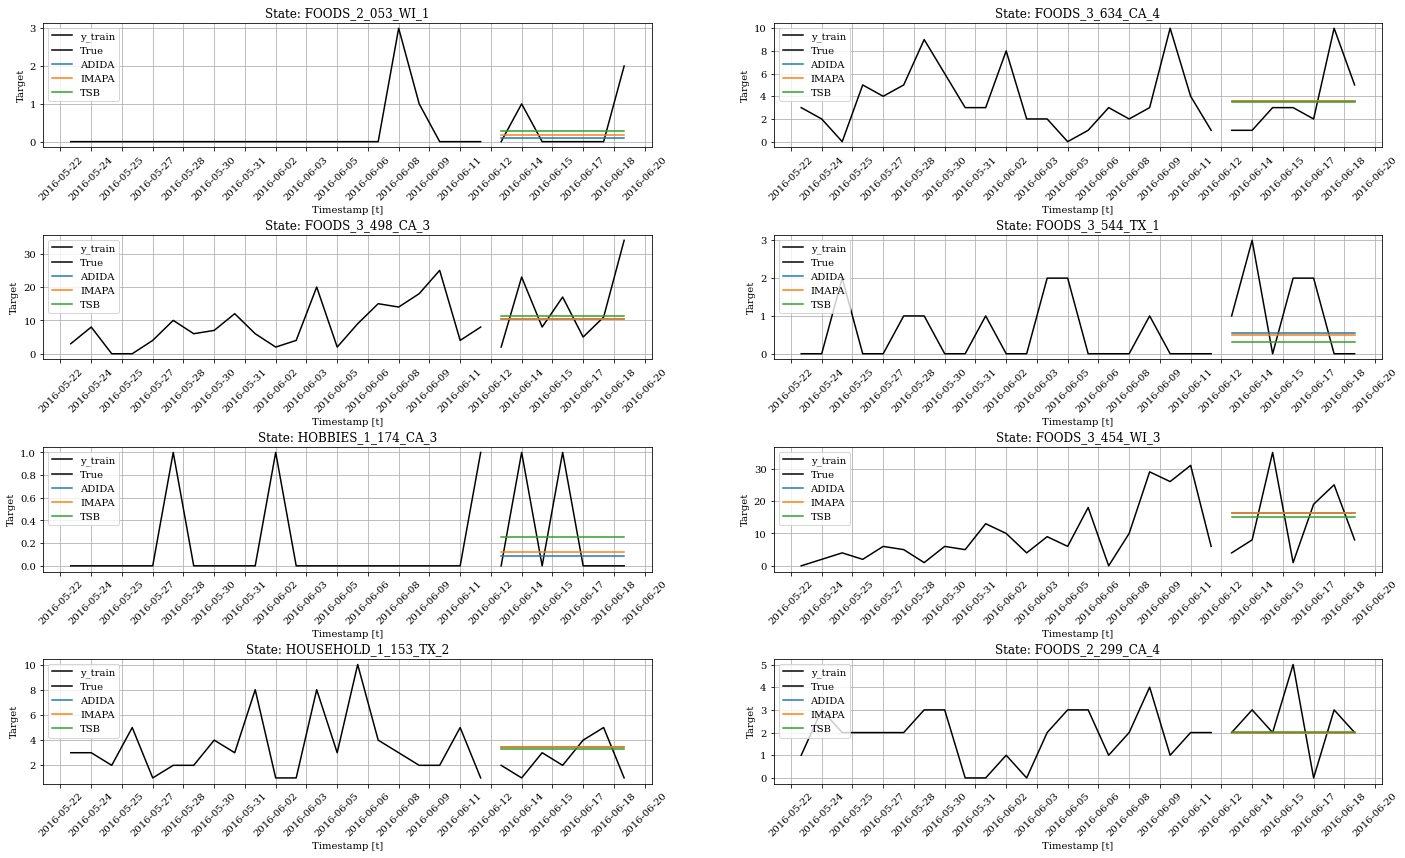

In [ ]:
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

plot_grid(Y_train_df.groupby('unique_id').tail(3*horizon), 
          plot_titles=plot_titles, 
          model_cols=['ADIDA', 'IMAPA', 'TSB'], 
          df_test=Y_test_df)

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/examples/IntermittentData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>